# Deep Learning Solution Method with All-in-One Expectation Operator (PyTorch)

**Converted from TensorFlow to PyTorch**

This notebook implements the Euler residual minimization approach from Maliar, Maliar and Winant (2019) for solving a consumption-saving problem with occasionally binding borrowing constraints.

Key ideas:
- Parameterize decision rules with neural networks
- Use stochastic optimization (train on randomly sampled grid points)
- All-in-one expectation: use two independent random draws to eliminate correlation between residual terms

In [118]:
import torch
import torch.nn as nn
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm
import quantecon as qe

# Set device - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Model 

The model is a standard, toy-RBC model. A household maximizes
$$V(Z,K)=u(c)+\beta \mathbb{E}[V(Z',K')],$$
subject to the budget constraint 
$$K'+C=ZK^{\alpha} + (1-\delta) K,$$
and $u(c)=\frac{c^{1-\gamma}}{1-\gamma}$. We are looking for a policy function $K'=\sigma(Z,K)$ that satisfies the Euler equation 
$$C^{-\gamma}=\beta\mathbb{E}[C^{-\gamma}(1+\alpha ZK^{'\alpha-1}-\delta)],$$
and with 
$$C=ZK^{\alpha} + (1-\delta) K-\sigma(Z,K);$$
and 
$$C'=Z'K^{',\alpha}+(1-\delta)K'-\sigma(Z',K').$$

## Model Parameters

In [119]:
# Model parameters

## Preferences
beta = 0.9 
gamma = 2.0 

## Firms
alpha = 1/3 
delta = 0.05 

## TFP 
sigma_Z = 0.01
rho_Z = 0.9
mu_Z = np.exp(1/2 * sigma_Z**2 / (1 - rho_Z**2))

In [120]:
def production_function(Z, K):
    """Cobb-Douglas production function"""
    return Z * K**alpha 

def coh_fun(Z, K):
    return production_function(Z, K) + (1 - delta) * K

def r_fun(Z, K):
    """Return the interest rate given Z and K"""
    return alpha * production_function(Z, K) / K - delta 

def c_fun(savings_rate, Z, K):
    """Consumption function given savings rate, TFP Z and capital K"""
    coh = coh_fun(Z, K)
    return (1 - savings_rate) * coh

## Stochastic Solution Domain

For AR(1) processes, the ergodic distribution has standard deviation $\sigma_z = \frac{\sigma}{\sqrt{1-\rho^2}}$

In [121]:
# Steady-state 
r = 1/beta - 1 
Z_ss = 1
K_ss = ((r + delta) / (alpha * Z_ss))**(1/(alpha-1))
Y_ss = K_ss**alpha
C_ss = Y_ss - delta * K_ss 
savings_rate_ss = K_ss / (Y_ss + (1 - delta) * K_ss)

# bounds for endogenous state variable
Kmin = K_ss * 0.8
Kmax = K_ss * 1.2
K_grid = np.linspace(Kmin, Kmax, 500)

In [122]:
print(Kmin)
print(K_ss )
print(Kmax )

2.38078329013432
2.9759791126679
3.57117493520148


## Neural Network Definition


In [123]:
class DecisionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), # two inputs 
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1) # one output
        )
        ## Initialize with He uniform (similar to TensorFlow's he_uniform)
        #for layer in self.net:
        #    if isinstance(layer, nn.Linear):
        #        nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        #        nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        return self.net(x)

perceptron = DecisionNetwork().to(device)
print(perceptron)

DecisionNetwork(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [124]:
def policy_function(Z, K):
    """Decision rule: maps states to savings rate"""
    
    # Normalize inputs to roughly [-1, 1] range
    Z_normalized = (Z-mu_Z) / sigma_Z / 2
    K_normalized = 2.0 * (K - Kmin) / (Kmax - Kmin) - 1.0
    
    # Stack inputs: shape (n, 2)
    s = torch.stack([Z_normalized, K_normalized], dim=1)
    
    # Forward pass through network
    x = perceptron(s)  # (n, 1)
    
    # Savings rate in [0,1]
    savings_rate = torch.sigmoid(x[:, 0])
        
    return torch.clamp(savings_rate, max = 0.9999)

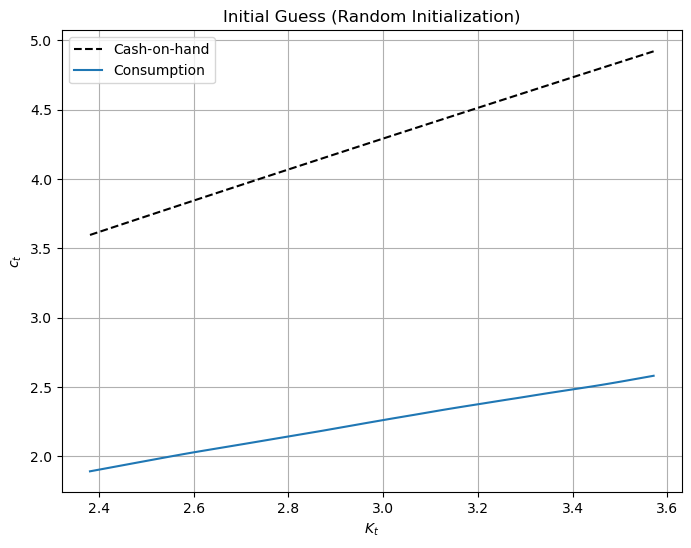

In [125]:
# Plot initial guess (random initialization)
with torch.no_grad():
    Kvec = torch.linspace(Kmin, Kmax, 100, device=device)
    ones = torch.ones_like(Kvec)  # Z = 1 (level value at steady state)
    savings_rate_vec = policy_function(ones, Kvec)
    consumption_vec = c_fun(savings_rate_vec, ones, Kvec)

plt.figure(figsize=(8, 6))
plt.plot(Kvec.cpu(), coh_fun(ones, Kvec).cpu(), linestyle='--', color='black', label='Cash-on-hand')
plt.plot(Kvec.cpu(), consumption_vec.cpu(), label='Consumption')
plt.xlabel("$K_t$")
plt.ylabel("$c_t$")
plt.title("Initial Guess (Random Initialization)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def euler_residuals(Z, K, eps):
    """
    Euler residuals with Monte Carlo expectation over epsilon shocks.

    Assumes: log Z' = rho * log Z + eps,  eps ~ N(0, sigma_eps^2)
    (If you have a nonzero drift, add it below.)

    Args:
        iz: current index of TFP in the grid, shape (batch_size,)
        K: current capital, shape (batch_size,)
        n_mc: number of Monte Carlo draws per state

    Returns:
        R: Euler equation residual, shape (batch_size,)
    """
    # Current Z (levels) from grid and batch size
    n = K.shape[0]

    # Current decisions
    savings_rate = policy_function(Z, K)
    coh = coh_fun(Z, K)
    K_next = savings_rate * coh
    C = coh - K_next

    # LHS: u'(C)
    LHS = C**(-gamma)

    # Compute Z' in levels: Z' = exp(rho * log Z + eps)
    logZ = torch.log(Z)
    logZ_next = rho_Z * logZ + eps
    Z_next = torch.exp(logZ_next)

    # Next-period policy and consumption
    savings_rate_next = policy_function(Z_next, K_next)
    C_next = c_fun(savings_rate_next, Z_next, K_next)

    # Future returns and marginal utility
    r_next = r_fun(Z_next, K_next)
    MU_next = C_next**(-gamma)
    RHS = beta * MU_next * (1.0 + r_next)

    # Residual
    R = RHS / LHS - 1.0
    return R


## Objective Function 

In [127]:
def sample_Z_ergodic(n, rho, sigma_eps, *, device=None, dtype=torch.float32):
    if not (-1.0 < rho < 1.0):
        raise ValueError("Need |rho| < 1 for a stationary (ergodic) distribution.")
    device = device or torch.device("cpu")
    rho = torch.as_tensor(rho, device=device, dtype=dtype)
    sigma_eps = torch.as_tensor(sigma_eps, device=device, dtype=dtype)

    sigma_x = sigma_eps / torch.sqrt(1.0 - rho**2)          # std of log Z in stationarity
    x = sigma_x * torch.randn(n, device=device, dtype=dtype) # mean 0
    Z = torch.exp(x)
    return Z

def objective_function(n):
    """
    Objective function: minimize E[R1 * R2] where R is the Euler residual.
    
    Uses the all-in-one expectation trick with two independent shock draws.
    
    Args:
        n: Number of state samples (Z, K)
    
    Returns:
        loss: Mean product of Euler residuals
    """
    # Sample current states from ergodic distribution
    Z = sample_Z_ergodic(n, rho_Z, sigma_Z, device=device)
    K = torch.rand(n, device=device) * (Kmax - Kmin) + Kmin

    # Compute Euler residual with two independent shocks
    eps_1 = sigma_Z * torch.randn(n, device=device)
    R1 = euler_residuals(Z, K, eps_1)

    eps_2 = sigma_Z * torch.randn(n, device=device)
    R2 = euler_residuals(Z, K, eps_2)
    
    # Minimize product of residuals (all-in-one expectation)
    R_squared = R1 * R2
    return torch.mean(R_squared)

## Test the Objective

In [128]:
n = 256
v = objective_function(n)
print(f"Initial objective value: {v.item():.6f}")

Initial objective value: 0.823760


## Training Loop

In [129]:
optimizer = torch.optim.Adam(perceptron.parameters(), lr=1e-4)

def training_step():
    optimizer.zero_grad()
    loss = objective_function(n)  
    loss.backward()
    optimizer.step()
    return loss.item()

def train(K):
    vals = []
    for k in tqdm(range(K)):
        val = training_step()
        vals.append(val)
    return vals

In [130]:
results = train(50_000)

100%|██████████| 50000/50000 [00:45<00:00, 1089.06it/s]


## Training Convergence

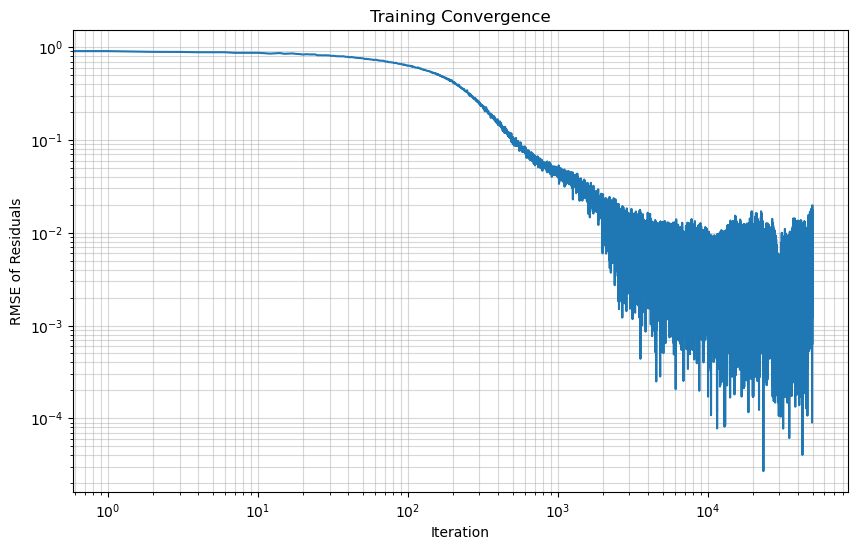

In [131]:
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(np.abs(results)))  # abs() for numerical safety
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('RMSE of Residuals')
plt.title('Training Convergence')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

In [132]:
euler_residuals(torch.tensor([1], device=device), torch.tensor([K_ss], device=device), torch.tensor([0.0], device=device))

tensor([-0.0017], grad_fn=<SubBackward0>)

In [133]:
print(policy_function(torch.tensor([1], device=device), torch.tensor([K_ss], device=device)) )
print(savings_rate_ss)

tensor([0.6241], grad_fn=<ClampBackward1>)
0.6976744186046512


In [134]:
from vfi_rbc_solution import vfi, extract_policies, K_grid, Z_grid as Z_grid_vfi

_, policy_K = vfi(tol = 1e-6, max_iter = 1000, verbose = True)
policy_C, policy_s = extract_policies(policy_K)

Iteration 1: max value function diff = 0.38342161
Iteration 2: max value function diff = 0.10355714
Iteration 3: max value function diff = 0.04174340
Iteration 4: max value function diff = 0.03708006
Iteration 5: max value function diff = 0.03294068
Iteration 6: max value function diff = 0.02926267
Iteration 7: max value function diff = 0.02599346
Iteration 8: max value function diff = 0.02308811
Iteration 9: max value function diff = 0.02050861
Iteration 10: max value function diff = 0.01821829
Iteration 11: max value function diff = 0.01618668
Iteration 12: max value function diff = 0.01438552
Iteration 13: max value function diff = 0.01278960
Iteration 14: max value function diff = 0.01137498
Iteration 15: max value function diff = 0.01012232
Iteration 16: max value function diff = 0.00901151
Iteration 17: max value function diff = 0.00802734
Iteration 18: max value function diff = 0.00715482
Iteration 19: max value function diff = 0.00638036
Iteration 20: max value function diff = 

## Compare Deep Learning vs VFI

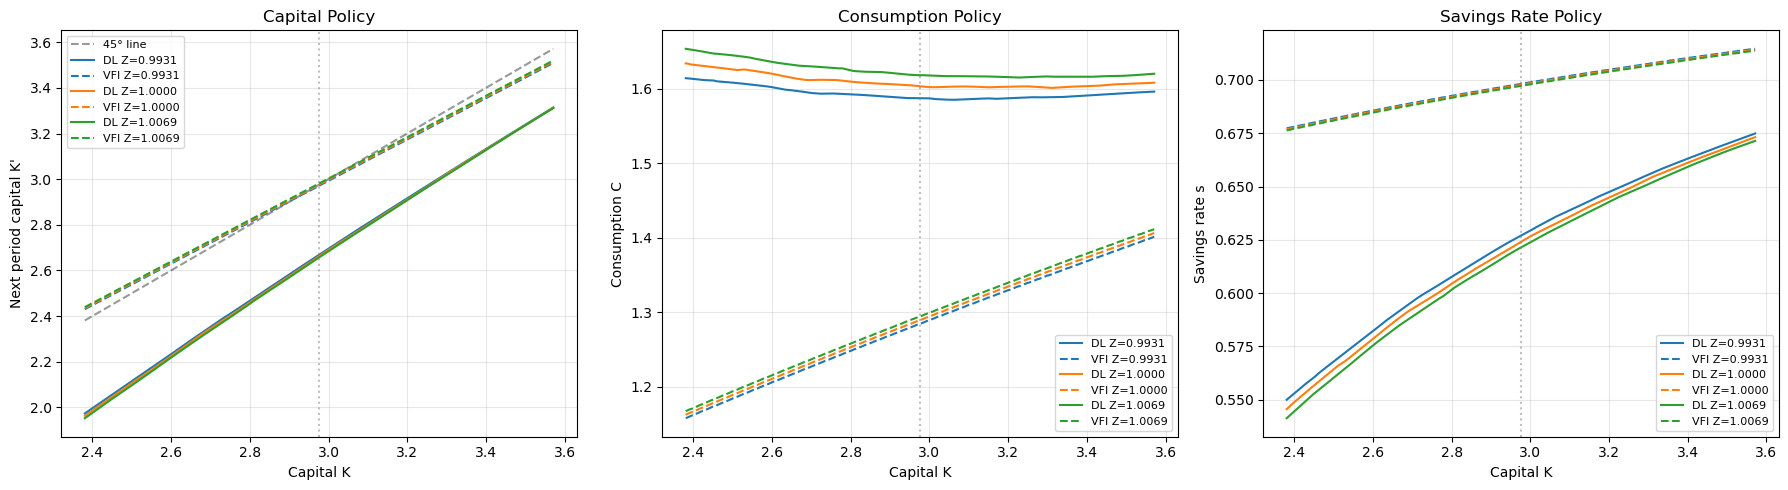

RMSE(savings rate) at Z≈1: 8.210101e-02


In [135]:
n_Z = policy_C.shape[0]
# Compute DL policy on the VFI grid for each Z state
K_tensor = torch.tensor(K_grid, dtype=torch.float32, device=device)

policy_s_dl = np.zeros((n_Z, K_grid.size))
policy_K_dl = np.zeros((n_Z, K_grid.size))
policy_C_dl = np.zeros((n_Z, K_grid.size))

with torch.no_grad():
    for iz in range(n_Z):
        Z_level = float(Z_grid_vfi[iz])
        Z_tensor = torch.full_like(K_tensor, Z_level)
        savings = policy_function(Z_tensor, K_tensor)
        coh = coh_fun(Z_tensor, K_tensor)
        K_next = savings * coh
        C = coh - K_next

        policy_s_dl[iz, :] = savings.cpu().numpy()
        policy_K_dl[iz, :] = K_next.cpu().numpy()
        policy_C_dl[iz, :] = C.cpu().numpy()

# Plot comparisons at low/mid/high Z
z_indices = [0, n_Z // 2, n_Z - 1]
labels = [f"Z={Z_grid_vfi[i]:.4f}" for i in z_indices]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Capital policy
ax = axes[0]
ax.plot(K_grid, K_grid, "k--", alpha=0.4, label="45° line")
for i, iz in enumerate(z_indices):
    ax.plot(K_grid, policy_K_dl[iz, :], color=colors[i], label=f"DL {labels[i]}")
    ax.plot(K_grid, policy_K[iz, :], color=colors[i], linestyle="--", label=f"VFI {labels[i]}")
ax.axvline(x=K_ss, linestyle=":", color="gray", alpha=0.5)
ax.set_xlabel("Capital K")
ax.set_ylabel("Next period capital K'")
ax.set_title("Capital Policy")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Consumption policy
ax = axes[1]
for i, iz in enumerate(z_indices):
    ax.plot(K_grid, policy_C_dl[iz, :], color=colors[i], label=f"DL {labels[i]}")
    ax.plot(K_grid, policy_C[iz, :], color=colors[i], linestyle="--", label=f"VFI {labels[i]}")
ax.axvline(x=K_ss, linestyle=":", color="gray", alpha=0.5)
ax.set_xlabel("Capital K")
ax.set_ylabel("Consumption C")
ax.set_title("Consumption Policy")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Savings rate policy
ax = axes[2]
for i, iz in enumerate(z_indices):
    ax.plot(K_grid, policy_s_dl[iz, :], color=colors[i], label=f"DL {labels[i]}")
    ax.plot(K_grid, policy_s[iz, :], color=colors[i], linestyle="--", label=f"VFI {labels[i]}")
ax.axvline(x=K_ss, linestyle=":", color="gray", alpha=0.5)
ax.set_xlabel("Capital K")
ax.set_ylabel("Savings rate s")
ax.set_title("Savings Rate Policy")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Quick numeric comparison at Z ≈ 1
iz_mid = n_Z // 2
rmse_s = np.sqrt(np.mean((policy_s_dl[iz_mid, :] - policy_s[iz_mid, :])**2))
print(f"RMSE(savings rate) at Z≈1: {rmse_s:.6e}")